In [1]:
# !pip install levenshtein
# !pip install fuzzywuzzy

In [30]:
# import packages for data handling/manipulation, plotting and for Approximate string matching

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process

In [31]:
# import WHO alcohol data

drinks = pd.read_csv('WHO_data_alc.csv', low_memory=False, header=0)

In [32]:
drinks.columns

Index(['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode',
       'ParentLocation', 'Location type', 'SpatialDimValueCode', 'Location',
       'Period type', 'Period', 'IsLatestYear', 'Dim1 type', 'Dim1',
       'Dim1ValueCode', 'Dim2 type', 'Dim2', 'Dim2ValueCode', 'Dim3 type',
       'Dim3', 'Dim3ValueCode', 'DataSourceDimValueCode', 'DataSource',
       'FactValueNumericPrefix', 'FactValueNumeric', 'FactValueUoM',
       'FactValueNumericLowPrefix', 'FactValueNumericLow',
       'FactValueNumericHighPrefix', 'FactValueNumericHigh', 'Value',
       'FactValueTranslationID', 'FactComments', 'Language', 'DateModified'],
      dtype='object')

Location = Country

Period = year

Dim1 = Alcohol cateogory

FactValueNumeric = Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)

In [33]:
# keep important columns

df = drinks[['Location', 'Period', 'Dim1', 'FactValueNumeric', 'FactValueNumericLow','FactValueNumericHigh']]
df

,Location,Period,Dim1,FactValueNumeric,FactValueNumericLow,FactValueNumericHigh
0,Afghanistan,2019,Beer,0.00,0.0,0.0
1,Afghanistan,2019,Other alcoholic beverages,0.00,0.0,0.0
2,Afghanistan,2019,Wine,0.00,0.0,0.0
3,Algeria,2019,Other alcoholic beverages,0.00,0.0,0.0
4,Andorra,2019,Other alcoholic beverages,0.00,0.0,0.0
...,...,...,...,...,...,...
47784,United States of America,1960,Spirits,3.26,NaN,NaN
47785,United States of America,1960,Beer,3.75,NaN,NaN
47786,Austria,1960,Beer,4.70,NaN,NaN
47787,United States of America,1960,All types,7.83,NaN,NaN


In [38]:
# copying the dataframe to manipulate it for plotting

df_plot = df.copy()
df_plot.columns = ['Location', 'Period', 'Beverage Type', 'Value', 'Low Estimate', 'High Estimate']

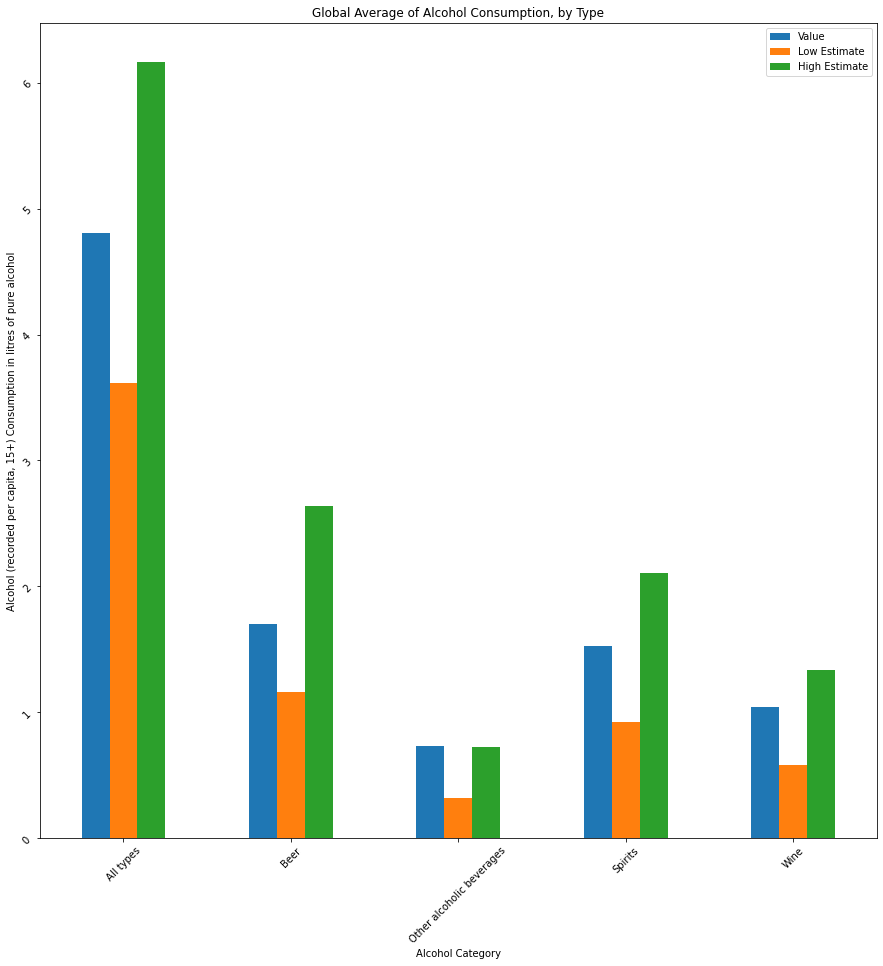

In [42]:
ax = df_plot.drop(['Period'], axis=1).groupby('Beverage Type').mean().plot(kind='bar', figsize=(15,15), title='Global Average of Alcohol Consumption, by Type', 
                                                        ylabel='Alcohol (recorded per capita, 15+) Consumption in litres of pure alcohol', xlabel='Alcohol Category')

ax.tick_params(rotation=45)


In [8]:
# separate the data into alcohol types

all_types = df[df['Dim1'] == 'All types'].drop(['Dim1','FactValueNumericLow', 'FactValueNumericHigh'], axis=1).rename(columns={'FactValueNumeric':'All Types Volume'})
beer = df[df['Dim1'] == 'Beer'].drop(['Dim1','FactValueNumericLow', 'FactValueNumericHigh'], axis=1).rename(columns={'FactValueNumeric':'Beer Volume'})
wine = df[df['Dim1'] == 'Wine'].drop(['Dim1','FactValueNumericLow', 'FactValueNumericHigh'], axis=1).rename(columns={'FactValueNumeric':'Wine Volume'})
spirits = df[df['Dim1'] == 'Spirits'].drop(['Dim1','FactValueNumericLow', 'FactValueNumericHigh'], axis=1).rename(columns={'FactValueNumeric':'Spirits Volume'})
other = df[df['Dim1'] == 'Other alcoholic beverages'].drop(['Dim1','FactValueNumericLow', 'FactValueNumericHigh'], axis=1).rename(columns={'FactValueNumeric':'Other Volume'})

In [43]:
# import the data for the gdp per capita, growth per capita & ppp per captia

gdp_pc = pd.read_csv('gdp_per_capita.csv')
gdp_pc = gdp_pc.rename(columns={'Country Name':'Location'})

gdp_g_pc = pd.read_csv('gdp_per_capita_growth.csv')
gdp_g_pc = gdp_g_pc.rename(columns={'Country Name':'Location'})

gdp_ppp = pd.read_csv('gdp_ppp_per_capita.csv')
gdp_ppp = gdp_ppp.rename(columns={'Country Name':'Location'})

In [11]:
# approximate string matching fucntion, to find differences in the country names between the datasets

def NameFinder(name):
    alc_names = df['Location'].drop_duplicates().to_list()
    gdp_names = gdp_pc['Location'].drop_duplicates().to_list()
    alc_name = process.extract(name, alc_names, limit=1)
    gdp_name = process.extract(name, gdp_names, limit=1)

    print('Country Name in GDP Dataset', gdp_name, 'Country Name in Alc Dataset', alc_name)
    return gdp_name,alc_name

In [12]:
# returns the number of locations that do not match, the list of the names that do not match

gdp_locs = gdp_pc['Location'].drop_duplicates().to_list()
alc_locs = df['Location'].drop_duplicates().to_list()
len(gdp_locs), len(alc_locs)

closest_match=[]
for i in gdp_locs:
    fm = process.extract(i, alc_locs, limit=1)
    closest_match.append([i, fm[0]])

non_match=[]
for i in closest_match:
    if i[1][1] < 100:
        non_match.append(i)

print(len(non_match))

91


In [65]:
# countries with non-matching names - Bahamas, Bolivia, Ivory Coast, Egypt, UK, Gambia, Iran, St. Lucia, Moldova, Macedonia, Tanzania,  USA, Venexuela, Vietnam, Yemen

g, a = NameFinder('United States')

Country Name in GDP Dataset [('United States of America', 90)] Country Name in Alc Dataset [('United States of America', 90)]


In [14]:
# replace names is the gdp datasets that don't match with those in the alcohol data

gdp_pc.loc[gdp_pc['Location'] == g[0][0], 'Location'] = a[0][0]

gdp_g_pc.loc[gdp_g_pc['Location'] == g[0][0], 'Location'] = a[0][0]

gdp_ppp.loc[gdp_ppp['Location'] == g[0][0], 'Location'] = a[0][0]

In [15]:
# # save the corrected datasets

# gdp_pc.to_csv('gdp_per_capita.csv')
# gdp_g_pc.to_csv('gdp_per_capita_growth.csv')
# gdp_ppp.to_csv('gdp_ppp_per_capita.csv')

In [72]:
# function to find the gdp of a desired country

def CountryGDP(country):
    country_gdp = gdp_pc[gdp_pc['Location'] == country].T.drop(['Location', 'Unnamed: 65', 'Unnamed: 0'])
    country_gdp['Year'] = country_gdp.index
    country_gdp['Year'] = country_gdp['Year'].astype(int)
    country_gdp.columns = ['GDP', 'Year']
    country_gdp = country_gdp.reset_index()
    country_gdp = country_gdp.drop(['index'], axis=1)
    return country_gdp

In [106]:
# function to find the total alcohol consumption of a desired country

def CountryConspumtion(country):
    country_cons = all_types[all_types['Location'] == country][['Period','All Types Volume']].reset_index().drop(['index'], axis=1)
    country_cons.columns = ['Year','alc_cons_litre']
    country_cons = country_cons.sort_values('Year')
    return country_cons

In [93]:
# function to plot the gdp of a country vs the consumption on the same axis

def TwoAxisPlot(df1, df2, country):
    x1 = np.arange(0, len(df1), step=1)
    y1 = df1['GDP'].to_list()
    x2 = np.arange(0, len(df2), step=1)
    y2 = df2['alc_cons_litre'].to_list()
    years = df2['Year'].to_list()

    fig, ax = plt.subplots(figsize=(16,8))

    color = 'tab:red'
    ax.set_ylabel('GDP', color=color)
    ax.plot(x1, y1, color=color, label='GDP')
    ax.tick_params(axis='y', labelcolor=color)
    ax2 = ax.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Alcohol Consumption', color=color)
    ax2.plot(x2, y2, color=color, label='Alcohol Consumption')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()

    ax.set_xticks(np.arange(len(df2)))
    ax.set_xticklabels(years)
    ax.tick_params(labelrotation=45)
    ax.set_title(f'Normalised GDP vs Total Alcohol Consumption, {country}')
    return

In [19]:
# fucntion to collate the alcohol data, manipulate the GDP data into a usable format and merge the two
        # fucntio merges the alchol dataframes, selects the gdp data where location names match, transposes the gdp data and renames the columns, resets index
        # The create a dataframe for each country in the gdp dataset before concatting them all together - done so that the alchol and gdp data are in the same format so that they can be merged
        # the gdp dataframe and the alcholo dataframe are then merged together, dropping and NaN values

def DataSorter(gdp_df):
    merge = all_types.merge(beer).merge(wine).merge(spirits).merge(other).sort_values(by=['Location', 'Period']).reset_index().drop(['index'], axis=1)
    gdp_filt = gdp_df.loc[gdp_df['Location'].isin(merge['Location'])].drop(['2020','Unnamed: 0','Unnamed: 65'], axis=1)
    gdp_T = gdp_filt.T
    gdp_T = gdp_T.rename(columns=gdp_T.iloc[0]).iloc[1:,:].reset_index().rename(columns={'index': 'Period'})
    years = gdp_T.Period.to_list()
    locs = gdp_T.columns.to_list()
    pop = locs.pop(0)

    df_list=[]
    for i in locs:
        df_l = pd.DataFrame(list(zip(years, gdp_T[i].to_list())), columns=['Period', 'GDP'])
        df_l['Location'] = i
        df_list.append(df_l)

    print('No. of seperate DFs created equal to length of countries (from above)',len(df_list))
    gdp_concat = pd.concat(df_list)
    gdp_concat['Period'] = gdp_concat['Period'].astype(int)
    final_merge = merge.merge(gdp_concat)
    final_merge = final_merge.dropna()
    return final_merge

In [20]:
gdp_pc_merge = DataSorter(gdp_pc)
gdp_g_pc_merge = DataSorter(gdp_g_pc)
gdp_ppp_merge = DataSorter(gdp_ppp)

No. of seperate DFs created equal to length of countries (from above) 175
No. of seperate DFs created equal to length of countries (from above) 175
No. of seperate DFs created equal to length of countries (from above) 175


In [21]:
# gdp_pc_merge.to_csv('merged_gdp_pc.csv')
# gdp_g_pc_merge.to_csv('merged_gdp_g_pc.csv')
# gdp_ppp_merge.to_csv('merged_gdp_ppp_pc.csv')

In [53]:
    # summary stats

gdp_pc_merge.drop(columns=['Period']).describe()

,All Types Volume,Beer Volume,Wine Volume,Spirits Volume,Other Volume,GDP
count,6530.000000,6530.000000,6530.000000,6530.000000,6530.000000,6530.000000
mean,4.817186,1.702672,0.932966,1.486108,0.712724,8066.087003
std,3.984066,1.741868,1.835191,1.750167,1.688134,14288.449750
min,0.000000,0.000000,0.000000,0.000000,0.000000,22.795345
25%,1.350000,0.300000,0.012000,0.100000,0.000000,651.582128
50%,4.015000,1.090000,0.130000,0.940000,0.010000,2166.974843
75%,7.550000,2.700000,0.970000,2.287500,0.430000,7779.738401
max,19.890000,9.960000,18.740000,14.440000,13.060000,123514.196686


In [24]:
gdp_g_pc_merge.drop(columns=['Period']).describe()

,All Types Volume,Beer Volume,Wine Volume,Spirits Volume,Other Volume,GDP
count,6349.000000,6349.000000,6349.000000,6349.000000,6349.000000,6349.000000
mean,4.823227,1.707050,0.942716,1.494695,0.696540,1.917651
std,3.964700,1.711774,1.847258,1.760528,1.615174,5.585587
min,0.000000,0.000000,0.000000,0.000000,0.000000,-64.992369
25%,1.390000,0.310000,0.016000,0.100000,0.000000,-0.245106
50%,4.010000,1.130000,0.130000,0.950000,0.010000,2.055111
75%,7.520000,2.720000,0.980000,2.290000,0.440000,4.377587
max,19.890000,9.960000,18.740000,14.440000,13.060000,121.779472


In [26]:
gdp_ppp_merge.drop(columns=['Period']).describe()

,All Types Volume,Beer Volume,Wine Volume,Spirits Volume,Other Volume,GDP
count,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000
mean,4.788391,1.788711,0.950662,1.496167,0.570155,14355.106886
std,3.925423,1.712766,1.571085,1.721181,1.517723,18071.340379
min,0.000000,0.000000,0.000000,0.000000,0.000000,285.404911
25%,1.260000,0.330000,0.020000,0.120000,0.000000,2675.593695
50%,3.990000,1.230000,0.160000,0.970000,0.010000,7393.298339
75%,7.810000,2.940000,1.200000,2.250000,0.270000,18199.383029
max,17.870000,9.960000,10.010000,14.440000,13.060000,141634.703825
